In [ ]:
%%capture
!apt-get update
!pip install pyglet
!pip install gym pyvirtualdisplay
!pip install xvfbwrapper
!apt-get install -y xvfb python-opengl ffmpeg
!pip install tensorflow==2.1.* 
import gym
from gym.wrappers import Monitor
from collections import deque
import tensorflow as tf
import numpy as np
import random
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()
from statistics import mean
from matplotlib import pyplot as pl

`Environment initialization`

In [ ]:
env = gym.make('CartPole-v0')
num_features = env.observation_space.shape[0]
num_actions = env.action_space.n

`Agent`

In [ ]:
class Agent:

  def __init__(self, main_model, target_model, env, gamma, optimizer, loss_fn):
    self.main_model = main_model
    self.target_model = target_model
    self.env = env 
    self.discount = gamma
    self.optimizer = optimizer 
    self.loss_fn = loss_fn
    
  def select_epsilon_greedy_action(self, state, epsilon): 
    state = tf.expand_dims(state, axis=0)
    result = tf.random.uniform((1,))
    if result < epsilon:
      return self.env.action_space.sample()
    else:
      return tf.argmax(self.main_model(state)[0]).numpy()
  
  def train_step(self, states, actions, rewards, next_states, dones):
    next_qs_main = self.main_model(next_states)
    next_qs_argmax = tf.argmax(next_qs_main, axis=-1)
    num_actions = self.main_model.num_actions 
    next_action_mask = tf.one_hot(next_qs_argmax, num_actions)
    next_qs_target = self.target_model(next_states)
    masked_next_qs = tf.reduce_sum(next_action_mask * next_qs_target, axis=-1)
    target = rewards + (1. - dones) * self.discount * masked_next_qs

    with tf.GradientTape() as tape:
      qs = self.main_model(states)
      num_actions = self.main_model.num_actions
      action_masks = tf.one_hot(actions, num_actions)
      masked_qs = tf.reduce_sum(action_masks * qs, axis=-1)
      loss = self.loss_fn(target, masked_qs)
    grads = tape.gradient(loss, self.main_model.trainable_variables)
    self.optimizer.apply_gradients(zip(grads, self.main_model.trainable_variables))
    return loss

`Build DDQN agent model`

In [ ]:
class DDQN(tf.keras.Model):
  """Dense neural network class."""
  def __init__(self, num_actions):
    super(DDQN, self).__init__()
    self.num_actions = num_actions
    self.dense1 = tf.keras.layers.Dense(32, activation="relu")
    self.dense2 = tf.keras.layers.Dense(32, activation="relu")
    self.dense3 = tf.keras.layers.Dense(self.num_actions, dtype=tf.float32) # no activation
    
  def call(self, x):
    """Forward pass."""
    x = self.dense1(x)
    x = self.dense2(x)
    return self.dense3(x)

`Experience replay buffer`

In [ ]:
class ReplayBuffer(object):
  """Experience replay buffer that samples uniformly."""
  def __init__(self, size):
    self.buffer = deque(maxlen=size)

  def add(self, state, action, reward, next_state, done):
    self.buffer.append((state, action, reward, next_state, done))

  def __len__(self):
    return len(self.buffer)

  def sample(self, num_samples):
    states, actions, rewards, next_states, dones = [], [], [], [], []
    idx = np.random.choice(len(self.buffer), num_samples)
    for i in idx:
      elem = self.buffer[i]
      state, action, reward, next_state, done = elem
      states.append(np.array(state, copy=False))
      actions.append(np.array(action, copy=False))
      rewards.append(reward)
      next_states.append(np.array(next_state, copy=False))
      dones.append(done)
    states = np.array(states)
    actions = np.array(actions)
    rewards = np.array(rewards, dtype=np.float32)
    next_states = np.array(next_states)
    dones = np.array(dones, dtype=np.float32)
    return states, actions, rewards, next_states, dones

`Main training loop`

In [ ]:
num_model_run = 5
mean_rewards_models = []
rewards_models = []
for n in range(num_model_run):

  # hiperparameters
  num_episodes = 1000
  epsilon = 1
  batch_size = 32
  discount = 0.99
  buffer = ReplayBuffer(100000)
  approx_iterations = 1e3
  epsilon_min = 0.05
  epsilon_decay = (epsilon_min / epsilon) ** (1 / approx_iterations)
  cur_frame = 0

  # model istantiation
  main_nn = DDQN(num_actions)
  target_nn = DDQN(num_actions)
  optimizer = tf.keras.optimizers.Adam(1e-4)
  mse = tf.keras.losses.MeanSquaredError()

  # agent istantiation
  agent = Agent(main_nn, target_nn, env, discount, optimizer, mse) 
  last_100_ep_rewards = []
  mean_last_100_ep_rewards = []

  agent = Agent(main_nn, target_nn, env, discount, optimizer, mse) 
  last_100_ep_rewards = []
  mean_last_100_ep_rewards = []

  for episode in range(num_episodes+1):
    state = env.reset()
    ep_reward, done = 0, False
    while not done:
      action = agent.select_epsilon_greedy_action(state,epsilon)
      next_state, reward, done, info = env.step(action)
      ep_reward += reward
      
      buffer.add(state, action, reward, next_state, done)
      state = next_state

      cur_frame += 1
      if cur_frame % 2000 == 0:
        target_nn.set_weights(main_nn.get_weights())

      if len(buffer) >= batch_size:
        states, actions, rewards, next_states, dones = buffer.sample(batch_size)
        loss = agent.train_step(states, actions, rewards, next_states, dones)

    epsilon *= epsilon_decay

    if episode != 0:
      rewards_models.append(ep_reward) 
    
    last_100_ep_rewards.append(ep_reward)
    if len(last_100_ep_rewards) == 100:
      last_100_ep_rewards = last_100_ep_rewards[1:]
      
    if episode % 50 == 0:
      mean_last_100_ep_rewards.append(np.mean(last_100_ep_rewards))
      mean_rewards_models.append(np.mean(last_100_ep_rewards))

  env.close()

`Plot average mean and std dev reward along episodes over several runs`

In [ ]:
def plot_mean_std_reward(models_rewards, episodes_num, model_run_num):
  rewards_tot = np.array(models_rewards)
  rewards_tot = rewards_tot.reshape(model_run_num, episodes_num)
  mean = rewards_tot.mean(axis=0)
  standard_dev = rewards_tot.std(axis=0)
  pl.plot(mean)
  pl.fill_between(range(episodes_num), mean-2*standard_dev, mean+2*standard_dev, alpha=0.3, facecolor='r')
  pl.show()

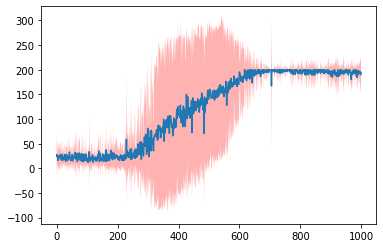

In [ ]:
plot_mean_std_reward(rewards_models, num_episodes, num_model_run)

`Evaluation loop => video display result of trained DDQN agent`

In [ ]:
def show_video():
  """Enables video recording of gym environment and shows it."""
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Video not found")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [ ]:
env = wrap_env(gym.make('CartPole-v0'))
state = env.reset()
done = False
ep_rew = 0
while not done:
  env.render()
  action = agent.select_epsilon_greedy_action(state,epsilon=0.01)
  state, reward, done, info = env.step(action)
  ep_rew += reward
print('Episode reward: {}'.format(ep_rew))
env.close()
show_video()

Episode reward: 200.0
